In [17]:
# -------------------- IMPORTS --------------------
import os
import subprocess

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from faster_whisper import WhisperModel


# -------------------- CONFIG --------------------
FFMPEG_PATH = r"C:\Users\Dhanya\Downloads\ffmpeg-8.0.1-essentials_build\ffmpeg-8.0.1-essentials_build\bin"


# -------------------- PDF LOADER --------------------
def load_pdfs(pdf_paths):
    all_pages = []
    for path in pdf_paths:
        loader = PyPDFLoader(path)
        pages = loader.load()
        all_pages.extend(pages)
    return all_pages


# -------------------- YOUTUBE → WHISPER (SAFE) --------------------
def transcribe_youtube(url):
    audio_file = "temp_audio.mp3"

    result = subprocess.run(
        [
            "yt-dlp",
            "-f", "bestaudio",
            "-x",
            "--audio-format", "mp3",
            "--ffmpeg-location", FFMPEG_PATH,
            "-o", audio_file,
            url
        ],
        capture_output=True,
        text=True
    )

    # 🔴 HARD VALIDATION (THIS FIXES YOUR ERROR)
    if result.returncode != 0 or not os.path.exists(audio_file):
        raise RuntimeError(
            f"YouTube audio download failed.\n{result.stderr}"
        )

    model = WhisperModel("base", device="cpu", compute_type="int8")
    segments, _ = model.transcribe(audio_file)

    text = " ".join(seg.text for seg in segments)

    return Document(
        page_content=text,
        metadata={
            "source": "youtube",
            "url": url,
            "type": "audio_transcript"
        }
    )


# -------------------- CHUNKING --------------------
def chunk_documents(all_docs, chunk_size=1000, chunk_overlap=200):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    return splitter.split_documents(all_docs)


# -------------------- USER-DRIVEN PIPELINE --------------------
def build_and_chunk_knowledge_base(pdf_paths=None, youtube_url=None):
    pdf_paths = pdf_paths or []

    # ✅ INPUT VALIDATION
    if not pdf_paths and not youtube_url:
        raise ValueError(
            "No input provided. Please upload at least one PDF or provide a YouTube link."
        )

    all_docs = []

    # PDFs
    if pdf_paths:
        all_docs.extend(load_pdfs(pdf_paths))

    # YouTube (optional)
    if youtube_url:
        yt_doc = transcribe_youtube(youtube_url)
        all_docs.append(yt_doc)

    # Chunk everything together
    chunks = chunk_documents(all_docs)

    return chunks


# -------------------- DEV TEST (REMOVE IN FINAL UI) --------------------
pdf_paths = [
    r"D:\Gen AI\Rag\Rag_project\EMBEDDED SYSTEMS DESIGN.pdf"
]

youtube_url = "https://www.youtube.com/watch?v=viZrOnJclY0"

chunks = build_and_chunk_knowledge_base(
    pdf_paths=pdf_paths,
    youtube_url=youtube_url
)

print("Total chunks created:", len(chunks))


Total chunks created: 283


In [18]:
len(pdf_paths)

1

In [19]:
from langchain_community.embeddings import HuggingFaceEmbeddings

In [20]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    encode_kwargs={"normalize_embeddings": True}
) 

C:\Users\Dhanya\AppData\Local\Temp\ipykernel_12208\2989020726.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


In [21]:
from langchain_community.vectorstores import Chroma
persist_directory = "./chroma_db"

vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    collection_name="my_knowledge_base",
    persist_directory=persist_directory
)

vectorstore.persist()

C:\Users\Dhanya\AppData\Local\Temp\ipykernel_12208\1957358231.py:11: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [22]:
print(vectorstore._collection.count())

566


In [23]:
question = "What is an embedded system?"

In [24]:
vectorstore.similarity_search(question, k=3)

[Document(metadata={'page': 19, 'creator': 'Microsoft® Word 2019', 'producer': 'Microsoft® Word 2019', 'moddate': '2025-12-16T09:51:52+05:30', 'total_pages': 138, 'source': 'D:\\Gen AI\\Rag\\Rag_project\\EMBEDDED SYSTEMS DESIGN.pdf', 'page_label': '20', 'author': 'MRCET', 'creationdate': '2025-12-16T09:51:52+05:30'}, page_content='into small-scale, medium-scale and large-scale/complex. \n6. The presences of embedded system vary from simple electronic system toys to complex \nflight and missile control systems. \n7. Embedded systems are designed to serve the purpose of any one or combination of data \ncollection/storage/representation, data processing, monitoring, control or application \nspecific user interface. \n8. Wearable devices refer to embedded systems which are incorporated into accessories and \napparels. It envisions the bonding of embedded technology in our day to day lives. \nOBJECTIVE QUESTIONS \n1. Embedded systems are \n(a) General Purpose (b) Special Purpose \n2. Embedd

In [25]:
vectorstore.similarity_search_with_score(question, k=3)

[(Document(metadata={'page_label': '20', 'author': 'MRCET', 'total_pages': 138, 'page': 19, 'producer': 'Microsoft® Word 2019', 'moddate': '2025-12-16T09:51:52+05:30', 'source': 'D:\\Gen AI\\Rag\\Rag_project\\EMBEDDED SYSTEMS DESIGN.pdf', 'creationdate': '2025-12-16T09:51:52+05:30', 'creator': 'Microsoft® Word 2019'}, page_content='into small-scale, medium-scale and large-scale/complex. \n6. The presences of embedded system vary from simple electronic system toys to complex \nflight and missile control systems. \n7. Embedded systems are designed to serve the purpose of any one or combination of data \ncollection/storage/representation, data processing, monitoring, control or application \nspecific user interface. \n8. Wearable devices refer to embedded systems which are incorporated into accessories and \napparels. It envisions the bonding of embedded technology in our day to day lives. \nOBJECTIVE QUESTIONS \n1. Embedded systems are \n(a) General Purpose (b) Special Purpose \n2. Embed

**Retrieval**


In [26]:
vectorstore.max_marginal_relevance_search(question, k=3, fetch_k=10)

[Document(metadata={'author': 'MRCET', 'page': 19, 'producer': 'Microsoft® Word 2019', 'moddate': '2025-12-16T09:51:52+05:30', 'creator': 'Microsoft® Word 2019', 'source': 'D:\\Gen AI\\Rag\\Rag_project\\EMBEDDED SYSTEMS DESIGN.pdf', 'page_label': '20', 'total_pages': 138, 'creationdate': '2025-12-16T09:51:52+05:30'}, page_content='into small-scale, medium-scale and large-scale/complex. \n6. The presences of embedded system vary from simple electronic system toys to complex \nflight and missile control systems. \n7. Embedded systems are designed to serve the purpose of any one or combination of data \ncollection/storage/representation, data processing, monitoring, control or application \nspecific user interface. \n8. Wearable devices refer to embedded systems which are incorporated into accessories and \napparels. It envisions the bonding of embedded technology in our day to day lives. \nOBJECTIVE QUESTIONS \n1. Embedded systems are \n(a) General Purpose (b) Special Purpose \n2. Embedd

**Meta Data Filtering**

In [27]:
vectorstore.similarity_search(
    question,
    k=3,
    filter={"source": "D:\\Gen AI\\Rag\\Rag_project\\EMBEDDED SYSTEMS DESIGN.pdf"}
)

[Document(metadata={'moddate': '2025-12-16T09:51:52+05:30', 'creator': 'Microsoft® Word 2019', 'source': 'D:\\Gen AI\\Rag\\Rag_project\\EMBEDDED SYSTEMS DESIGN.pdf', 'producer': 'Microsoft® Word 2019', 'page_label': '20', 'total_pages': 138, 'page': 19, 'creationdate': '2025-12-16T09:51:52+05:30', 'author': 'MRCET'}, page_content='into small-scale, medium-scale and large-scale/complex. \n6. The presences of embedded system vary from simple electronic system toys to complex \nflight and missile control systems. \n7. Embedded systems are designed to serve the purpose of any one or combination of data \ncollection/storage/representation, data processing, monitoring, control or application \nspecific user interface. \n8. Wearable devices refer to embedded systems which are incorporated into accessories and \napparels. It envisions the bonding of embedded technology in our day to day lives. \nOBJECTIVE QUESTIONS \n1. Embedded systems are \n(a) General Purpose (b) Special Purpose \n2. Embedd

**Groq**

In [28]:
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

In [29]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.7,
    max_tokens=1000
)

In [30]:
response = llm.invoke("Write a poem about nature")

In [31]:
response.content

"In twilight's hush, where forest dreams,\nThe trees stand tall, their vigil keeps.\nTheir leaves, a rustling whisper, sway,\nAs wind's soft breath, through branches creeps.\n\nThe sun, a fiery orb, descends,\nPainting the sky, with colors that blend.\nOrange, pink, and purple, dance and play,\nAs day succumbs to the night's dark way.\n\nThe stars, like diamonds, twinkle bright,\nA celestial show, beyond our sight.\nThe world, in darkness, finds its peace,\nAs nature's lullaby, our souls release.\n\nThe river's voice, a gentle song,\nEchoes through the valley, all day long.\nIts waters flow, a winding stream,\nThat quenches thirst, and calms the dream.\n\nThe mountains rise, a majestic height,\nTheir peaks, a challenge, to the morning light.\nThe earth, a canvas, vibrant and wide,\nA masterpiece, where nature's beauty resides.\n\nIn this grand tapestry, we find our place,\nA thread, that's woven, in the natural space.\nWe breathe, the air, that's fresh and clean,\nAnd feel, the pulse, 

**Prompt Engineering**

In [32]:
system_prompt = {"You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question"
                 "If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."
                 "Answer all questions to the best of your ability."
}

In [33]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

In [34]:
System_Message = [SystemMessage(content=system_prompt)]

In [35]:
question = "What is an embedded system?"

In [36]:
vectorstore.similarity_search(question, k=3)

[Document(metadata={'page': 19, 'creationdate': '2025-12-16T09:51:52+05:30', 'producer': 'Microsoft® Word 2019', 'source': 'D:\\Gen AI\\Rag\\Rag_project\\EMBEDDED SYSTEMS DESIGN.pdf', 'author': 'MRCET', 'total_pages': 138, 'page_label': '20', 'moddate': '2025-12-16T09:51:52+05:30', 'creator': 'Microsoft® Word 2019'}, page_content='into small-scale, medium-scale and large-scale/complex. \n6. The presences of embedded system vary from simple electronic system toys to complex \nflight and missile control systems. \n7. Embedded systems are designed to serve the purpose of any one or combination of data \ncollection/storage/representation, data processing, monitoring, control or application \nspecific user interface. \n8. Wearable devices refer to embedded systems which are incorporated into accessories and \napparels. It envisions the bonding of embedded technology in our day to day lives. \nOBJECTIVE QUESTIONS \n1. Embedded systems are \n(a) General Purpose (b) Special Purpose \n2. Embedd

In [39]:
import pandas as pd
docs = vectorstore.similarity_search_with_relevance_scores(question, k=3)

_docs = pd.DataFrame(
    [(question, doc[0].page_content, doc[0].metadata.get("source"), doc[0].metadata.get("page"), doc[1]) for doc in docs],
    columns=["query", "paragraph", "document", "page_number", "relevant_score"]
)

In [40]:
context = "\n\n".join(_docs["paragraph"])

In [41]:
context

'into small-scale, medium-scale and large-scale/complex. \n6. The presences of embedded system vary from simple electronic system toys to complex \nflight and missile control systems. \n7. Embedded systems are designed to serve the purpose of any one or combination of data \ncollection/storage/representation, data processing, monitoring, control or application \nspecific user interface. \n8. Wearable devices refer to embedded systems which are incorporated into accessories and \napparels. It envisions the bonding of embedded technology in our day to day lives. \nOBJECTIVE QUESTIONS \n1. Embedded systems are \n(a) General Purpose (b) Special Purpose \n2. Embedded system is \n(a) An electronic system (b) A pure mechanical system \n(c)An electro-mechanical system (d) (a) or (c) \n3. Which of the following is not true about embedded systems? \n(a) Built around specialized hardware (b) Always contain an operating system \n(c)Execution behavior may be deterministic (d) All of these (e) none 

In [51]:
from langchain_core.messages import SystemMessage, HumanMessage

system_prompt = """
"You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question"
"If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."
"Answer all questions to the best of your ability.
"""

human_content = f"""
Context:
{context}

Question:
{question}
"""

messages = [
    SystemMessage(content=system_prompt),   # ✅ string
    HumanMessage(content=human_content)      # ✅ string
]

response = llm.invoke(messages)
print(response.content)


An embedded system is an electronic/electromechanical system designed to perform a specific function. It is a combination of both hardware and firmware (software) that serves a particular purpose, such as data collection, processing, monitoring, or control. Embedded systems can range from simple electronic toys to complex flight and missile control systems.


In [52]:
from langgraph.checkpoint.memory import MemorySaver 
from langgraph.graph import START, MessagesState, StateGraph

workflow = StateGraph(state_schema=MessagesState)

#Define the function that calls the model

def call_model(state: MessagesState):
    system_prompt = (
        "You are a helpful assistant."
        "Answer all questions to the best of your ability."
    )

    messages = [SystemMessage(content=system_prompt)] + state ["messages"]
    response = llm.invoke(messages)
    return {"messages": response}

# Define the node and edge

workflow.add_node("model", call_model)
workflow.add_edge (START, "model")

#Add simple in-memory checkpointer
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

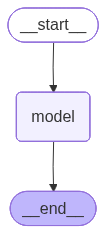

In [53]:
app

In [54]:
app.invoke(
    {
        "messages": [HumanMessage(content=human_content)]},
        config={"configurable": {"thread_id": "1"}}
)

{'messages': [HumanMessage(content='\nContext:\ninto small-scale, medium-scale and large-scale/complex. \n6. The presences of embedded system vary from simple electronic system toys to complex \nflight and missile control systems. \n7. Embedded systems are designed to serve the purpose of any one or combination of data \ncollection/storage/representation, data processing, monitoring, control or application \nspecific user interface. \n8. Wearable devices refer to embedded systems which are incorporated into accessories and \napparels. It envisions the bonding of embedded technology in our day to day lives. \nOBJECTIVE QUESTIONS \n1. Embedded systems are \n(a) General Purpose (b) Special Purpose \n2. Embedded system is \n(a) An electronic system (b) A pure mechanical system \n(c)An electro-mechanical system (d) (a) or (c) \n3. Which of the following is not true about embedded systems? \n(a) Built around specialized hardware (b) Always contain an operating system \n(c)Execution behavior 

In [56]:
app.invoke(
    {
        "messages": [HumanMessage(content="what did i ask you?")]},
        config={"configurable": {"thread_id": "1"}}
)

{'messages': [HumanMessage(content='\nContext:\ninto small-scale, medium-scale and large-scale/complex. \n6. The presences of embedded system vary from simple electronic system toys to complex \nflight and missile control systems. \n7. Embedded systems are designed to serve the purpose of any one or combination of data \ncollection/storage/representation, data processing, monitoring, control or application \nspecific user interface. \n8. Wearable devices refer to embedded systems which are incorporated into accessories and \napparels. It envisions the bonding of embedded technology in our day to day lives. \nOBJECTIVE QUESTIONS \n1. Embedded systems are \n(a) General Purpose (b) Special Purpose \n2. Embedded system is \n(a) An electronic system (b) A pure mechanical system \n(c)An electro-mechanical system (d) (a) or (c) \n3. Which of the following is not true about embedded systems? \n(a) Built around specialized hardware (b) Always contain an operating system \n(c)Execution behavior 